In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Activation
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


## Useful functions

In [2]:
def save_model(model, filename):
    model_json = model.to_json()
    with open(filename + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(filename + ".h5")
    print("Saved model to disk")

## Load data

In [3]:
DATA_FOLDER = "./data/"

In [4]:
df_training = pd.read_parquet(DATA_FOLDER + "training.parquet")

In [5]:
df_public_test = pd.read_parquet(DATA_FOLDER + "public_test.parquet")

In [6]:
df_private_test = pd.read_parquet(DATA_FOLDER + "private_test.parquet")

## Process data

In [7]:
x_train = df_training.as_matrix()[:,1:]
y_train = df_training.as_matrix()[:,0]
x_test = df_public_test.as_matrix()[:,1:]
y_test = df_public_test.as_matrix()[:,0]

c:\python3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
c:\python3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
c:\python3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\python3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [8]:
x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)

In [9]:
x_train = x_train.astype("float32")/255.
x_test = x_test.astype("float32")/255.

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
x_train.shape

(28709, 48, 48, 1)

## Create model

In [28]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation='relu', padding="same",
                 input_shape = (48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (5, 5), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Conv2D(filters = 512, kernel_size = (3, 3), activation='relu', padding="same"))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_28 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_29 (Batc (None, 24, 24, 128)       512       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 12, 12, 512)       590336    
__________

In [30]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [31]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [32]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [33]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [34]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=20, #Increase this when not on Kaggle kernel
                           validation_data=(x_test[:400,:], y_test[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/20
500/500 [==============================] - 744s 1s/step - loss: 2.4077 - acc: 0.1924 - val_loss: 1.9114 - val_acc: 0.2500
Epoch 2/20
500/500 [==============================] - 847s 2s/step - loss: 1.9677 - acc: 0.2193 - val_loss: 1.7943 - val_acc: 0.2725
Epoch 3/20
500/500 [==============================] - 835s 2s/step - loss: 1.8775 - acc: 0.2295 - val_loss: 1.7638 - val_acc: 0.2800
Epoch 4/20
500/500 [==============================] - 740s 1s/step - loss: 1.7919 - acc: 0.2723 - val_loss: 1.8449 - val_acc: 0.2475
Epoch 5/20
500/500 [==============================] - 799s 2s/step - loss: 1.7542 - acc: 0.2940 - val_loss: 1.6406 - val_acc: 0.3650
Epoch 6/20
500/500 [==============================] - 804s 2s/step - loss: 1.6521 - acc: 0.3470 - val_loss: 1.8966 - val_acc: 0.2925
Epoch 7/20
500/500 [==============================] - 794s 2s/step - loss: 1.5934 - acc: 0.3837 - val_loss: 1.6362 - val_acc: 0.3400
Epoch 8/20
500/500 [==============================] - 800s 2s/step - 

In [38]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           initial_epoch=20,
                           epochs=40, #Increase this when not on Kaggle kernel
                           validation_data=(x_test[:400,:], y_test[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 21/40
500/500 [==============================] - 737s 1s/step - loss: 1.1521 - acc: 0.5634 - val_loss: 1.0093 - val_acc: 0.6525
Epoch 22/40
500/500 [==============================] - 752s 2s/step - loss: 1.1608 - acc: 0.5713 - val_loss: 1.2338 - val_acc: 0.5625
Epoch 23/40
500/500 [==============================] - 817s 2s/step - loss: 1.1574 - acc: 0.5657 - val_loss: 1.0490 - val_acc: 0.6425
Epoch 24/40
500/500 [==============================] - 876s 2s/step - loss: 1.1337 - acc: 0.5770 - val_loss: 0.9932 - val_acc: 0.6425
Epoch 25/40
500/500 [==============================] - 894s 2s/step - loss: 1.1000 - acc: 0.5869 - val_loss: 0.9912 - val_acc: 0.6675
Epoch 26/40
500/500 [==============================] - 784s 2s/step - loss: 1.1090 - acc: 0.5825 - val_loss: 0.9679 - val_acc: 0.6650
Epoch 27/40
500/500 [==============================] - 891s 2s/step - loss: 1.1092 - acc: 0.5856 - val_loss: 0.9711 - val_acc: 0.6725
Epoch 28/40
500/500 [==============================] - 827s 2s

In [41]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           initial_epoch=40,
                           epochs=60, #Increase this when not on Kaggle kernel
                           validation_data=(x_test[:400,:], y_test[:400,:]), #For speed
                           callbacks=[annealer])
save_model(model, "./trained_models/best_60epochs")

Epoch 41/60
500/500 [==============================] - 740s 1s/step - loss: 1.0148 - acc: 0.6154 - val_loss: 0.9630 - val_acc: 0.6775
Epoch 42/60
500/500 [==============================] - 738s 1s/step - loss: 1.0293 - acc: 0.6180 - val_loss: 0.9438 - val_acc: 0.6825
Epoch 43/60
500/500 [==============================] - 705s 1s/step - loss: 1.0098 - acc: 0.6189 - val_loss: 0.9465 - val_acc: 0.6950
Epoch 44/60
500/500 [==============================] - 706s 1s/step - loss: 1.0044 - acc: 0.6263 - val_loss: 0.9367 - val_acc: 0.6925
Epoch 45/60
500/500 [==============================] - 711s 1s/step - loss: 1.0186 - acc: 0.6194 - val_loss: 0.9397 - val_acc: 0.6825
Epoch 46/60
500/500 [==============================] - 708s 1s/step - loss: 0.9980 - acc: 0.6315 - val_loss: 0.9555 - val_acc: 0.6825
Epoch 47/60
500/500 [==============================] - 711s 1s/step - loss: 1.0090 - acc: 0.6284 - val_loss: 0.9479 - val_acc: 0.6875
Epoch 48/60
500/500 [==============================] - 710s 1s

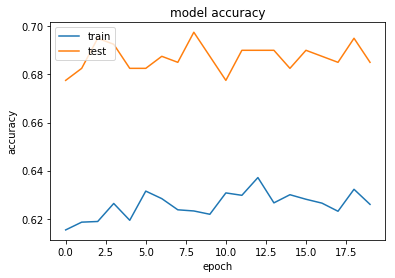

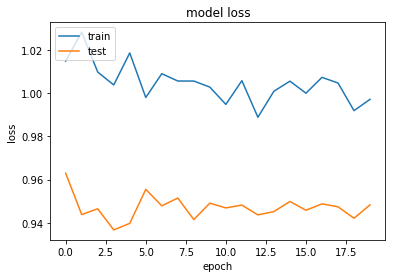

In [42]:
plot_history(hist)

In [ ]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           initial_epoch=60,
                           epochs=80, #Increase this when not on Kaggle kernel
                           validation_data=(x_test[:400,:], y_test[:400,:]), #For speed
                           callbacks=[annealer])
save_model(model, "./trained_models/best_80epochs")

Epoch 61/80
500/500 [==============================] - 743s 1s/step - loss: 0.9875 - acc: 0.6294 - val_loss: 0.9451 - val_acc: 0.6900
Epoch 62/80
500/500 [==============================] - 907s 2s/step - loss: 0.9962 - acc: 0.6305 - val_loss: 0.9433 - val_acc: 0.6825
Epoch 63/80
500/500 [==============================] - 1486s 3s/step - loss: 0.9944 - acc: 0.6342 - val_loss: 0.9467 - val_acc: 0.6900
Epoch 64/80
500/500 [==============================] - 1636s 3s/step - loss: 1.0094 - acc: 0.6287 - val_loss: 0.9443 - val_acc: 0.6875
Epoch 65/80
500/500 [==============================] - 1032s 2s/step - loss: 0.9898 - acc: 0.6387 - val_loss: 0.9432 - val_acc: 0.6875
Epoch 66/80
500/500 [==============================] - 1056s 2s/step - loss: 1.0003 - acc: 0.6239 - val_loss: 0.9419 - val_acc: 0.6875
Epoch 67/80
500/500 [==============================] - 824s 2s/step - loss: 1.0054 - acc: 0.6245 - val_loss: 0.9437 - val_acc: 0.6950
Epoch 68/80
500/500 [==============================] - 738

In [ ]:
final_loss, final_acc = model.evaluate(x_test, y_test, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

In [39]:
save_model(model, "./trained_models/best_40epochs")

Saved model to disk


In [36]:
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

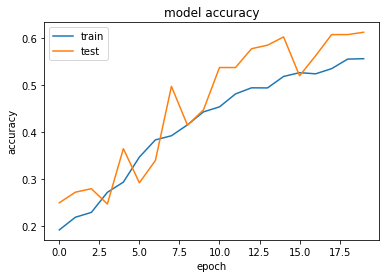

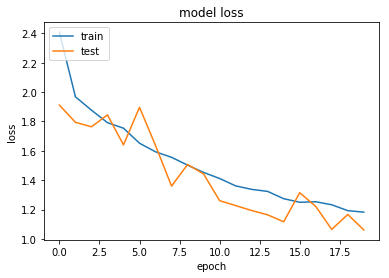

In [37]:
plot_history(hist)

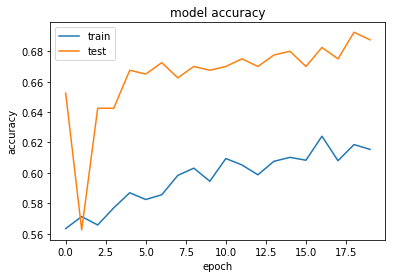

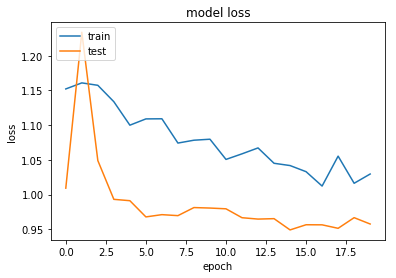

In [40]:
plot_history(hist)